In [81]:
#Importing relevant libraries
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
import pandas_datareader.data as reader
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
#Establishing the list of needed stocks
stock_list = ('ADBE', 'AEP', 'CSCO', 'EXC', 'GOOGL', 'INTC', 'LNT', 'MSFT', 'STLD', 'TMUS', 'TWTR', 'XEL')
stock_list

('ADBE',
 'AEP',
 'CSCO',
 'EXC',
 'GOOGL',
 'INTC',
 'LNT',
 'MSFT',
 'STLD',
 'TMUS',
 'TWTR',
 'XEL')

In [198]:
# Creating DataFrame for the future data which we download 
DF = pd.DataFrame(columns=['ROE','Beta'])

# Moving the bad_tickers list outside of the loop
bad_tickers = []

for i in stock_list:
    stock = yf.Ticker(i)
    
     # Checking if the company is delisted by using historical data for the company
    history = stock.history()
    
    if history.empty:
        # Adding the company to the bad tickers list if it is delisted
        bad_tickers.append(i)
        continue
        
    try:
        # Downloading data and calculating formulae
        ROE = stock.financials.loc['Net Income']/stock.balance_sheet.loc['Total Stockholder Equity']*100
        Mean_ROE = pd.Series(ROE.mean())
        Beta = pd.Series(stock.get_info()['beta'])

        # Updating the DataFrame with the calculated results inside the try block
        values_to_add = {'ROE': Mean_ROE.values[0].round(2), 'Beta': Beta.values[0].round(2)}
        row_to_add = pd.Series(values_to_add, name=i)
        DF = DF.append(row_to_add)
        # Printing a success message
        print('Downloaded:',i)
        
    except:
        bad_tickers.append(i) # Excluding bad tickers using except clause

Downloaded: ADBE
Downloaded: AEP
Downloaded: CSCO
Downloaded: EXC
Downloaded: GOOGL
Downloaded: INTC
Downloaded: LNT
Downloaded: MSFT
Downloaded: STLD
Downloaded: TMUS
- TWTR: No data found for this date range, symbol may be delisted
Downloaded: XEL


In [196]:
# Checking what stocks are in bad tickers 
bad_tickers

['TWTR']

In [199]:
# Making a copy of DataFrame to work with later
df = DF.copy()

# Scaling the data for its normal distribution 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #Calculating the mean and standard deviation for each feature in the data
df_values = scaler.fit_transform(df.values) #Using transform method for data to substract the mean and divide by standard deviation 

# Printing the new scaled data values
print(df_values)

[[ 1.05667712  1.31208401]
 [-0.89109929 -1.15709242]
 [ 0.86704659  0.4890252 ]
 [-1.23153124 -0.53979831]
 [ 0.03447828  0.72418486]
 [ 0.47062849 -0.21645378]
 [-0.84594917 -0.92193276]
 [ 1.83867729  0.34205041]
 [ 0.69908812  1.95877308]
 [-1.09156585 -0.83374789]
 [-0.90645034 -1.15709242]]


In [200]:
# Using KMeans clustering algorithm to group data into clusters
from sklearn.cluster import KMeans

#Fitting a KMeans clustering algorithm to the scaled values of the DataFrame
km_model = KMeans(n_clusters=2).fit(df_values) #Assuming k = 2

In [201]:
# Adding the cluster labels for each sample in the input data
clusters = km_model.labels_

#Displaying the new DataFrame after clustering
df['cluster']=clusters
df

,ROE,Beta,cluster
ADBE,31.99,1.26,1
AEP,10.42,0.42,0
CSCO,29.89,0.98,1
EXC,6.65,0.63,0
GOOGL,20.67,1.06,1
INTC,25.5,0.74,1
LNT,10.92,0.5,0
MSFT,40.65,0.93,1
STLD,28.03,1.48,1
TMUS,8.2,0.53,0


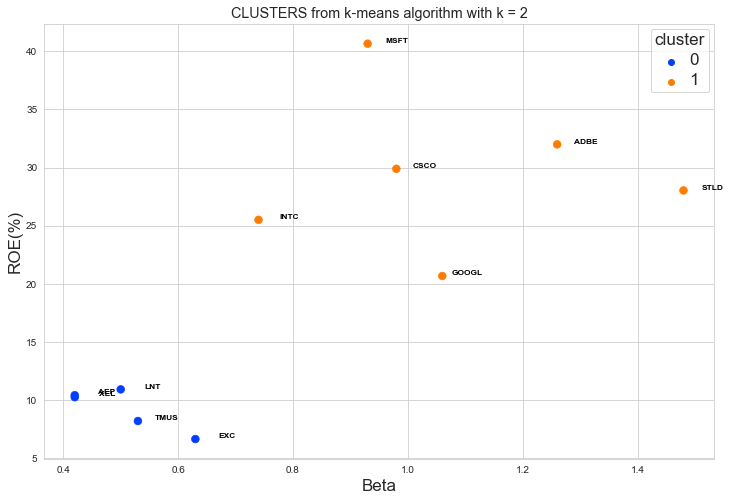

In [83]:
# Visualising clustering
plt.figure(figsize=(12, 8))

sns.set_style('whitegrid')
ax = sns.scatterplot(y="ROE(%)", x="Beta", edgecolor='face', hue="cluster",data=df, palette = 'bright',s=60)

plt.xlabel('Beta', size=17) #Setting x-axis
plt.ylabel('ROE(%)', size=17) #Setting y-axis
plt.setp(ax.get_legend().get_texts(), fontsize='17') # for text in legend
plt.setp(ax.get_legend().get_title(), fontsize='17') # for title in legend
plt.title('CLUSTERS from k-means algorithm with k = 2',fontsize='x-large') #Adding the title


for i in range(0,df.shape[0]):
     plt.text(df.Beta[i]+0.07, df['ROE(%)'][i]+0.01, df.index[i],horizontalalignment='right',verticalalignment='bottom', size='small', color='black', weight='semibold')

In [231]:
#Answering question: How is the similarity of stocks in terms of industry?
#Creating a new DataFrame with the clusters' group to compare sectors of the stocks
# Sector instead of industry: correlation in sectors will be more visually obvious and crucial to check 
# Industries differ within a similar sector and in my opinion, it won't be that obvious with industries
stock_list = ('ADBE', 'AEP', 'CSCO', 'EXC', 'GOOGL', 'INTC', 'LNT', 'MSFT', 'STLD', 'TMUS', 'XEL')
df1 = pd.DataFrame({'Tickers': stock_list, 'Cluster': df.iloc[:, 2], 'Sector': None}) 
for ticker in stock_list:
    # Creating a Ticker object for the ticker
    stock = yf.Ticker(ticker)
    
    # Getting the company information for the ticker
    info = stock.get_info()
    
    # Getting the sector of the company for the ticker
    sector = info['sector']
    
    # Setting the value of the 'Sector' column for the ticker
    df1.loc[df1['Tickers'] == ticker, 'Sector'] = sector

# Displaying the resulting DataFrame
print(df1)

      Tickers  Cluster                  Sector
ADBE     ADBE        1              Technology
AEP       AEP        0               Utilities
CSCO     CSCO        1              Technology
EXC       EXC        0               Utilities
GOOGL   GOOGL        1  Communication Services
INTC     INTC        1              Technology
LNT       LNT        0               Utilities
MSFT     MSFT        1              Technology
STLD     STLD        1         Basic Materials
TMUS     TMUS        0  Communication Services
XEL       XEL        0               Utilities


In [234]:
#Answering question: How is the similarity of stocks in terms of industry?
#Showing stocks with cluster 0 from DataFrame
cluster_0 = df1.loc[df1['Cluster'] == 0]
cluster_0 

,Tickers,Cluster,Sector
AEP,AEP,0,Utilities
EXC,EXC,0,Utilities
LNT,LNT,0,Utilities
TMUS,TMUS,0,Communication Services
XEL,XEL,0,Utilities


In [235]:
#Showing stocks with cluster 1 from DataFrame
cluster_1 = df1.loc[df1['Cluster'] == 1]
cluster_1 
#This shows that the stocks are divided in 2 groups (clusters) depending on their sector
#2 companies from Comunnication Services Sector are equally distributed between 2 clusters

,Tickers,Cluster,Sector
ADBE,ADBE,1,Technology
CSCO,CSCO,1,Technology
GOOGL,GOOGL,1,Communication Services
INTC,INTC,1,Technology
MSFT,MSFT,1,Technology
STLD,STLD,1,Basic Materials


In [247]:
#Fetching prices for stocks for cluster 0
multpl_stocks = reader.get_data_yahoo(cluster_0,
  start = '2010-01-01',
  end = '2020-12-30')
multpl_stocks = multpl_stocks[['Close']]
multpl_stocks

Attributes      Close                                             
Symbols           AEP        EXC        LNT        TMUS        XEL
Date                                                              
2010-01-04  34.939999  34.864479  15.175000   15.940000  21.080000
2010-01-05  34.540001  34.293865  15.530000   15.980000  20.830000
2010-01-06  34.889999  34.500713  15.650000   14.900000  20.870001
2010-01-07  35.189999  34.614838  15.735000   15.040000  20.780001
2010-01-08  35.610001  34.450787  16.040001   14.200000  20.790001
...               ...        ...        ...         ...        ...
2020-12-23  80.709999  29.750357  49.540001  132.229996  64.309998
2020-12-24  81.419998  29.835949  50.020000  132.919998  64.629997
2020-12-28  81.279999  30.106991  50.310001  133.000000  65.320000
2020-12-29  81.180000  29.835949  50.480000  133.139999  65.419998
2020-12-30  81.510002  29.907274  50.759998  133.279999  65.650002

[2768 rows x 5 columns]

In [250]:
# Calculating the pairwise correlations between all columns in the DataFrame for cluster 0
correlations = multpl_stocks.corr()

# Printing the resulting correlations for cluster 0
print('Correlations of cluster 0:', correlations)

Correlations of cluster 0: Attributes             Close                                        
Symbols                  AEP       EXC       LNT      TMUS       XEL
Attributes Symbols                                                  
Close      AEP      1.000000  0.308458  0.990421  0.893995  0.972569
           EXC      0.308458  1.000000  0.288240  0.314278  0.335776
           LNT      0.990421  0.288240  1.000000  0.923791  0.982802
           TMUS     0.893995  0.314278  0.923791  1.000000  0.953245
           XEL      0.972569  0.335776  0.982802  0.953245  1.000000


In [270]:
# Identifying the pair of stocks with the highest correlation 
# Selecting integers in the correlation matrix that are less than 1
corr_matrix = correlations.where(correlations < 1)

# Find the maximum correlation for each column
max_corr = corr_matrix.idxmax()

# Find the maximum value of the correlation matrix
max_corr_value = corr_matrix.max().max()
col, row = np.where(corr_matrix == max_corr_value)
print(f"The two stocks with the highest correlation are {correlations.columns[col[0]]} and {correlations.columns[row[0]]} with value {max_corr_value}")

The two stocks with the highest correlation are ('Close', 'AEP') and ('Close', 'LNT') with value 0.9904212188031295


In [251]:
#Fetching prices for stocks from cluster 1
multpl_stocks1 = reader.get_data_yahoo(cluster_1,
  start = '2010-01-01',
  end = '2020-12-30')
multpl_stocks1 = multpl_stocks1[['Close']]
multpl_stocks1

Attributes       Close                                                        
Symbols           ADBE       CSCO      GOOGL       INTC        MSFT       STLD
Date                                                                          
2010-01-04   37.090000  24.690001  15.684434  20.879999   30.950001  18.290001
2010-01-05   37.700001  24.580000  15.615365  20.870001   30.959999  18.180000
2010-01-06   37.619999  24.420000  15.221722  20.799999   30.770000  19.500000
2010-01-07   36.889999  24.530001  14.867367  20.600000   30.450001  19.370001
2010-01-08   36.689999  24.660000  15.065566  20.830000   30.660000  20.190001
...                ...        ...        ...        ...         ...        ...
2020-12-23  496.910004  44.380001  86.411499  46.570000  221.020004  36.369999
2020-12-24  499.859985  44.540001  86.708000  47.070000  222.750000  36.380001
2020-12-28  498.950012  44.919998  88.697998  47.070000  224.960007  35.980000
2020-12-29  502.109985  44.639999  87.888000  49.389999  224.149994  36.369999
2020-12-30  497.450012  44.480000  86.812500  48.750000  221.679993  36.590000

[2768 rows x 6 columns]

In [252]:
# Calculating the pairwise correlations between all columns in the DataFrame for cluster 1
correlations1 = multpl_stocks1.corr()

# Printing the resulting correlations for cluster 1
print('Correlations of cluster 1:', correlations1)

Correlations of cluster 1: Attributes             Close                                                  
Symbols                 ADBE      CSCO     GOOGL      INTC      MSFT      STLD
Attributes Symbols                                                            
Close      ADBE     1.000000  0.860881  0.953275  0.896346  0.993962  0.663848
           CSCO     0.860881  1.000000  0.893819  0.915409  0.839919  0.789070
           GOOGL    0.953275  0.893819  1.000000  0.928872  0.942680  0.784710
           INTC     0.896346  0.915409  0.928872  1.000000  0.889863  0.766534
           MSFT     0.993962  0.839919  0.942680  0.889863  1.000000  0.613917
           STLD     0.663848  0.789070  0.784710  0.766534  0.613917  1.000000


In [271]:
# Identifying the pair of stocks with the highest correlation 
# Selecting integers in the correlation matrix that are less than 1
corr_matrix1 = correlations1.where(correlations1 < 1)

# Find the maximum correlation for each column
max_corr1 = corr_matrix1.idxmax()

# Find the maximum value of the correlation matrix
max_corr_value1 = corr_matrix1.max().max()
col, row = np.where(corr_matrix1 == max_corr_value1)
print(f"The two stocks with the highest correlation are {correlations1.columns[col[0]]} and {correlations1.columns[row[0]]} with value {max_corr_value1}")

The two stocks with the highest correlation are ('Close', 'ADBE') and ('Close', 'MSFT') with value 0.9939619699244859
